# Using R extensions within Python programs
The R is a very powerful tool for statistical data analysis. Especially, it offers many advanced statistical models that are not (yet) available in Python. To make these modules accessible from Python, *rpy2* is a convenient way to execute R-code inside a Python environment. Not surprisingly, this also requires that R has been installed on the current system.

Personally, I am no great fan of R. It is very powerful, but compared to Python, the language seem unnatural and clunky to me.

Like Python, R is free, and can be obtained from https://cran.r-project.org/

Note that this is a very rudimentary demonstration, and only demonstrates that R code and graphics can be used quite simply from within Python.

author: Thomas Haslwanter date: Nov-2022

## rpy2

IPython enables you to execute R-modules via [rpy2](https://rpy2.github.io/doc/latest/html/introduction.html):

In [1]:
# Preliminaries: without those, I get a Warning/Error on Windows
import os
import rpy2
import rpy2.situation
os.environ["R_HOME"] = rpy2.situation.r_home_from_registry()
os.environ["R_USER"] = os.environ['USERPROFILE']

from rpy2.robjects.packages import importr

# import R's "base" package
base = importr('base')


In [2]:
from rpy2.robjects import r

%load_ext rpy2.ipython
%precision 3

C:\Programs\WPy64-39100\python-3.9.10.amd64\lib\site-packages\rpy2\robjects\packages.py:365: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


'%.3f'

## A simple example: scatter-plot
A typical use case one imagines is having some numpy arrays, wanting to compute some statistics of interest on these
 arrays and return the result back to python. Let's suppose we just want to fit a simple linear model to a scatterplot.

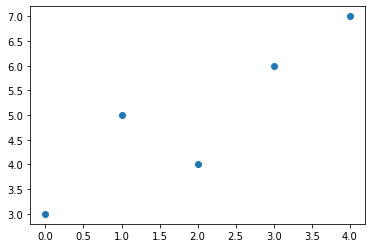

In [3]:
# First we generate and plot the data in Python
import numpy as np
import matplotlib.pyplot as plt

X = np.array([0,1,2,3,4])
Y = np.array([3,5,4,6,7])
plt.scatter(X, Y)

## Pushing Python variables into R, and executing R-commands in IPython

We can accomplish this by first pushing variables to R, fitting a model and returning the results. The line magic %Rpush copies its arguments to variables of the same name in rpy2. The %R line magic evaluates the string in rpy2 and returns the results. In this case, the coefficients of a linear model.

In [4]:
%Rpush X Y
%R lm(Y~X)$coef

array([3.2, 0.9])

In [5]:
# Note: %Rpush is equivalent to calling %R with just -i and no trailing code.
A = np.arange(20)
%R -i A
%R mean(A)

array([9.5])

In [6]:
# We can check that the computation in R is correct fairly easily:

Xr = X - X.mean()
Yr = Y - Y.mean()
slope = (Xr*Yr).sum() / (Xr**2).sum()
intercept = Y.mean() - X.mean() * slope
(intercept, slope)

(3.2, 0.9)

In [7]:
# It is also possible to return more than one value with %R.
%R resid(lm(Y~X)); coef(lm(X~Y))


array([-2.5,  0.9])

### Capturing literal output from R into IPython

In [8]:
# Unfortunately, the literal output from R does not work directly (yet):
%R summary(lm(Y~X))

R object with classes: ('summary.lm',) mapped to:
[LangSexpV..., LangSexpV..., FloatSexp..., FloatSexp..., ..., FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp...]
  call: <class 'rpy2.robjects.language.LangVector'>
  Rlang( lm(formula = Y ~ X) )
  terms: <class 'rpy2.robjects.Formula'>
  R object with classes: ('terms', 'formula') mapped to:
  residuals: <class 'rpy2.robjects.vectors.FloatArray'>
  R object with classes: ('array',) mapped to:
[-0.200000, 0.900000, -1.000000, 0.100000, 0.200000]
  coefficients: <class 'rpy2.robjects.vectors.FloatMatrix'>
  R object with classes: ('matrix',) mapped to:
[3.200000, 0.900000, 0.616441, 0.251661, 5.191085, 3.576237, 0.013884, 0.037386]
...
  sigma: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.810000]
  df: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.746667]
  r.squared: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[12.789474, 1.000000, 3.000000]
  adj.r.squared: <class 'rpy2.robjects.vectors.FloatMatrix'>
  R object with classes: ('matrix',) mapped to:
[0.600000, -0.200000, -0.200000, 0.100000]

Therefore we have to use a trick:
* We first "capture" the output of the R-command
* And then we display it, line-by-line

Note: "%%R" executes multiple R-commandlines 

In [9]:
%%R
X = c(1,2,3,4,5)
Y = c(1,2,3,6,5)
s = capture.output(summary(lm(Y~X)))

In [10]:
# to get the variable back in to Python, we use 
# r from rpy2.robjects
spy = r['s']

In [11]:
for line in spy[2:-1]:
    print(line)

lm(formula = Y ~ X)

Residuals:
        1         2         3         4         5 
-2.22e-16 -2.00e-01 -4.00e-01  1.40e+00 -8.00e-01 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -0.2000     1.0132  -0.197   0.8561  
X             1.2000     0.3055   3.928   0.0294 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9661 on 3 degrees of freedom
Multiple R-squared:  0.8372,	Adjusted R-squared:  0.7829 
F-statistic: 15.43 on 1 and 3 DF,  p-value: 0.02937


## Getting R-variables back into IPython

There are two  line magics, %Rpull and %Rget. Both are useful after some R code has been executed and there are variables
in the rpy2 namespace that one would like to retrieve. The main difference is that one returns the value (%Rget), while the other pulls it to self.shell.user_ns (%Rpull).

Imagine we've stored the results of some calculation in the variable "a" in rpy2's namespace. By using the %R magic, we can obtain these results and store them in b. We can also pull them directly to user_ns with %Rpull. They are both views on the same data.

In [12]:
b = %R a=resid(lm(Y~X))
#two equivalent ways of getting things into Python
%R -o a
%Rpull a

# and to use it in Python
c = r['a']

In [13]:
print(f'a = {a}')
print(f'b = {b}')
print(f'c = {c}')

a = <rpy2.rinterface.FloatSexpVector object at 0x0000028470C46940> [RTYPES.REALSXP]
b = [-2.22e-16 -2.00e-01 -4.00e-01  1.40e+00 -8.00e-01]
c =             1             2             3             4             5 
-2.220446e-16 -2.000000e-01 -4.000000e-01  1.400000e+00 -8.000000e-01 



In [14]:
%R d=resid(lm(Y~X)); e=coef(lm(Y~X))
%R -o d -o e
%Rpull e
print(d)
print(e)

print(r['e'])

[-2.22e-16 -2.00e-01 -4.00e-01  1.40e+00 -8.00e-01]
<rpy2.rinterface.FloatSexpVector object at 0x0000028470C3C8C0> [RTYPES.REALSXP]
(Intercept)           X 
       -0.2         1.2 



In [15]:
# The magic %Rget retrieves one variable from R.
%Rget A

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32)

## Plotting and capturing output

R's console (i.e. its stdout() connection) is captured by ipython, as are any plots which are published as PNG files like the notebook with arguments --pylab inline. As a call to %R may produce a return value (see above) we must ask what happens to a magic like the one below. The R code specifies that something is published to the notebook. If anything is published to the notebook, that call to %R returns None.


Call:
lm(formula = Y ~ X)

Residuals:
        1         2         3         4         5 
-2.22e-16 -2.00e-01 -4.00e-01  1.40e+00 -8.00e-01 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -0.2000     1.0132  -0.197   0.8561  
X             1.2000     0.3055   3.928   0.0294 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9661 on 3 degrees of freedom
Multiple R-squared:  0.8372,	Adjusted R-squared:  0.7829 
F-statistic: 15.43 on 1 and 3 DF,  p-value: 0.02937



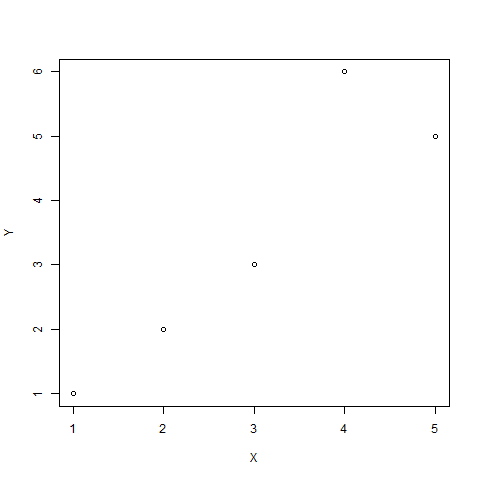

v1 is: [10.2]
v2 is: [10.2]


In [16]:
v1 = %R plot(X,Y); print(summary(lm(Y~X))); vv=mean(X)*mean(Y)
print('v1 is:', v1)
v2 = %R mean(X)*mean(Y)
print('v2 is:', v2)

## What value is returned from %R?

Some calls have no particularly interesting return value, the magic %R will not return anything in this case. The return value in rpy2 is actually NULL so %R returns None.

Also, if the return value of a call to %R (in line mode) has just been printed to the console, then its value is also not returned.

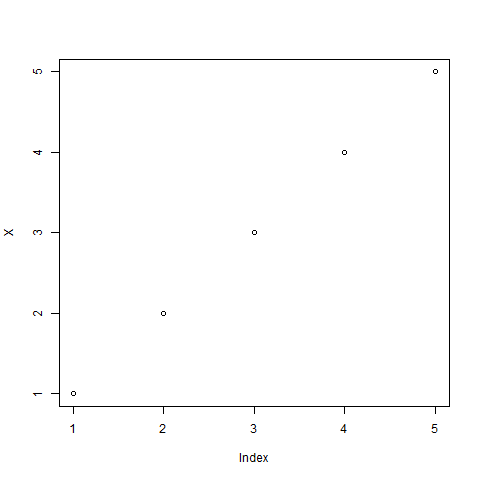

In [17]:
v = %R plot(X)
assert (v is None)

But, if the last value did not print anything to console, the value is returned:


In [18]:
v = %R print(summary(X)); X
print('v:', v)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       2       3       3       4       5 
v: [1. 2. 3. 4. 5.]


The return value can be suppressed by a trailing ';' or an -n argument.


In [19]:
%R -n X

In [20]:
%R X; 

## Cell level magic

Often, we will want to do more than a simple linear regression model. There may be several lines of R code that we want to 
use before returning to python. This is the cell-level magic.


For the cell level magic, inputs can be passed via the -i or --inputs argument in the line. These variables are copied 
from the shell namespace to R's namespace using rpy2.robjects.r.assign. It would be nice not to have to copy these into R: rnumpy ( https://rpy2.github.io/doc/latest/html/introduction.html ) has done some work to limit or at least make transparent the number of copies of an array. This seems like a natural thing to try to build on. Arrays can be output from R via the -o or --outputs argument in the line. All other arguments are sent to R's png function, which is the graphics device used to create the plots.

We can redo the above calculations in one ipython cell. We might also want to add some output such as a summary
 from R or perhaps the standard plotting diagnostics of the lm.


Call:
lm(formula = Y ~ X)

Residuals:
   1    2    3    4    5 
-0.2  0.9 -1.0  0.1  0.2 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   3.2000     0.6164   5.191   0.0139 *
X             0.9000     0.2517   3.576   0.0374 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7958 on 3 degrees of freedom
Multiple R-squared:   0.81,	Adjusted R-squared:  0.7467 
F-statistic: 12.79 on 1 and 3 DF,  p-value: 0.03739



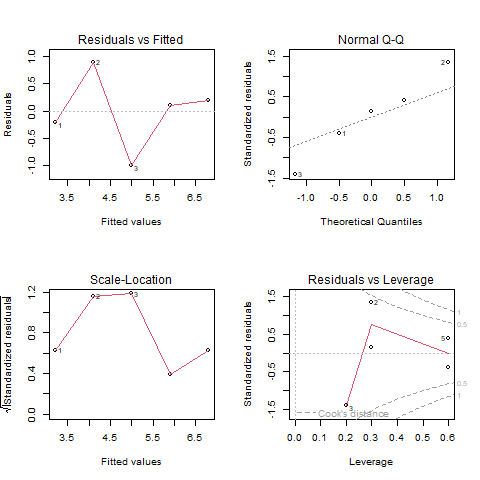

In [17]:
%%R -i X,Y -o XYcoef
XYlm = lm(Y~X)
XYcoef = coef(XYlm)
print(summary(XYlm))
par(mfrow=c(2,2))
plot(XYlm)

## Passing data back and forth

Currently, data is passed through RMagics.pyconverter when going from python to R and RMagics.Rconverter when 
going from R to python.

The syntax seems to be still under development. But with the examples here, I hope you will find your way through.

In [18]:
seq1 = np.arange(10)

In [19]:
%%R -i seq1 -o seq2
seq2 = rep(seq1, 2)

In [20]:
print(r['seq2'])
print(type(seq2))

 [1] 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9

<class 'numpy.ndarray'>


In [21]:
# To use the rpy2 object with numpy, you have to convert it to an array:
py_seq2 = np.array(r['seq2'])
py_seq2[::2] = 0
print(py_seq2)

[0 1 0 3 0 5 0 7 0 9 0 1 0 3 0 5 0 7 0 9]


Output from R seems to be not working for %%R at the moment:

In [22]:
%%R
print(seq2)

 [1] 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9


Once the array data has been passed to R, modifring its contents does not modify R's copy of the data.

In [23]:
seq1[0] = 200
%R print(seq1)

 [1] 0 1 2 3 4 5 6 7 8 9


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

But, if we pass data as both input and output, then the value of "data" in user_ns will be overwritten and the
new array will be a view of the data in R's copy.

In [24]:
print(seq1)
%R -i seq1 -o seq1
print(seq1)
seq1[0] = 200
%R print(seq1)
seq1_view = %R seq1
print(seq1_view)

[200   1   2   3   4   5   6   7   8   9]
[200   1   2   3   4   5   6   7   8   9]
 [1] 200   1   2   3   4   5   6   7   8   9
[200   1   2   3   4   5   6   7   8   9]


## R Graphics

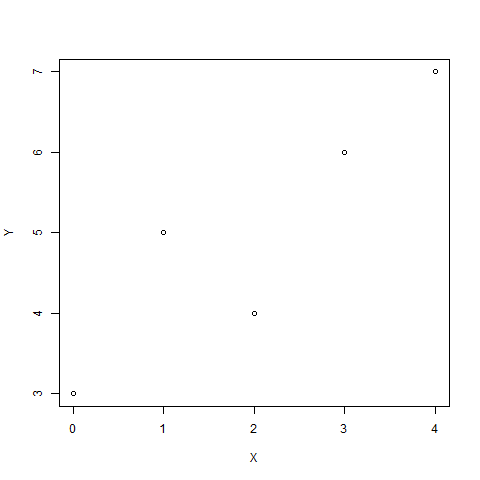

In [25]:
%R plot(X,Y)